In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
import segmentation_models_pytorch as smp

if torch.cuda.is_available():
    print("USING GPU...")
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)

USING GPU...


In [2]:
# Function to calculate Dice Similarity Coefficient
def dice_coefficient(outputs, targets):
    intersection = 2.0 * (outputs * targets).sum()
    union = (
        outputs.sum() + targets.sum() + 1e-7
    )  # Adding a small constant to avoid division by zero
    return intersection / union

# Function to train the model
def train(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            # print("\nLoss:\n")
            # print(loss)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            # print(total_loss)

        average_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")

        # Validation (if val_loader is provided)
        if val_loader is not None:
            model.eval()
            total_dice = 0.0
            total_val_loss = 0.0

            with torch.no_grad():
                for val_inputs, val_targets in val_loader:
                    val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)

                    val_outputs = model(val_inputs)
                    val_loss = criterion(val_outputs, val_targets)

                    total_val_loss += val_loss.item()
                    # print(total_val_loss)
                    total_dice += dice_coefficient(
                        (val_outputs.argmax(dim=1) == 1).float(), (val_targets == 1).float()
                    )
                    # print(total_dice)

            average_val_loss = total_val_loss / len(val_loader)
            average_dice = total_dice / len(val_loader)
            print(f"Validation Loss: {average_val_loss}, Dice Coefficient: {average_dice}")

In [3]:
# Load your data
train_folder = "/home/major/Major-Project-Experiments/data/organizedPancreasData/train_np"
test_folder = "/home/major/Major-Project-Experiments/data/organizedPancreasData/test_np"
label_folder = "/home/major/Major-Project-Experiments/data/organizedPancreasData/label_np"

train_txt = "/home/major/Major-Project-Experiments/data/organizedPancreasData/train.txt"
test_txt = "/home/major/Major-Project-Experiments/data/organizedPancreasData/test.txt"
label_txt = "/home/major/Major-Project-Experiments/data/organizedPancreasData/mask_train.txt"
val_label_txt = "/home/major/Major-Project-Experiments/data/organizedPancreasData/mask_val.txt"
val_txt = "/home/major/Major-Project-Experiments/data/organizedPancreasData/validation.txt"

train_images = []
test_images = []
val_images = []
mask_train = []
mask_val = []

N = 10

i = N
with open(train_txt) as file:
    for row in file:
        if i == 0:
            break
        i -= 1
        filename = row.strip('\n')
        train_images.append(np.load(train_folder + '/' + filename))

i = N
with open(label_txt) as file:
    for row in file:
        if i == 0:
            break
        i -= 1
        filename = row.strip('\n')
        mask_train.append(np.load(label_folder + '/' + filename))

i = N
with open(val_txt) as file:
    for row in file:
        if i == 0:
            break
        i -= 1
        filename = row.strip('\n')
        val_images.append(np.load(train_folder + '/' + filename))

i = N
with open(val_label_txt) as file:
    for row in file:
        if i == 0:
            break
        i -= 1
        filename = row.strip('\n')
        mask_val.append(np.load(label_folder + '/' + filename))

i = N
with open(test_txt) as file:
    for row in file:
        if i == 0:
            break
        i -= 1
        filename = row.strip('\n')
        test_images.append(np.load(test_folder + '/' + filename))

In [4]:
for i in range(10):
    print(train_images[i].shape, mask_train[i].shape)

(93, 512, 512) (93, 512, 512)
(97, 512, 512) (97, 512, 512)
(85, 512, 512) (85, 512, 512)
(81, 512, 512) (81, 512, 512)
(73, 512, 512) (73, 512, 512)
(86, 512, 512) (86, 512, 512)
(113, 512, 512) (113, 512, 512)
(72, 512, 512) (72, 512, 512)
(97, 512, 512) (97, 512, 512)
(97, 512, 512) (97, 512, 512)


In [5]:
train_2D_images = np.vstack(train_images)
print(train_2D_images.shape)

(894, 512, 512)


In [6]:
mask_2D_train = np.vstack(mask_train)
print(mask_2D_train.shape)

(894, 512, 512)


In [7]:
val_2D_images = np.vstack(val_images)
print(val_2D_images.shape)

(896, 512, 512)


In [8]:
mask_2D_val = np.vstack(mask_val)
print(mask_2D_val.shape)

(896, 512, 512)


In [9]:
test_2D_images = np.vstack(test_images)
print(test_2D_images.shape)

(1059, 512, 512)


In [10]:
# def remove_infinity(arr, N):
#     arr[arr == np.inf] = N
#     arr[arr == -np.inf] = -N
#     return arr

# train_2D_images = remove_infinity(train_2D_images, 7)
# mask_2D_train = remove_infinity(mask_2D_train, 7)
# val_2D_images = remove_infinity(val_2D_images, 7)
# mask_2D_val = remove_infinity(mask_2D_val, 7)
# test_2D_images = remove_infinity(test_2D_images, 7)

In [11]:
# Convert data to PyTorch tensors
train_images = torch.from_numpy(train_2D_images).float().unsqueeze(1)
val_images = torch.from_numpy(val_2D_images).float().unsqueeze(1)
test_images = torch.from_numpy(test_2D_images).float().unsqueeze(1)
mask_train = torch.from_numpy(mask_2D_train).long()
mask_val = torch.from_numpy(mask_2D_val).long()

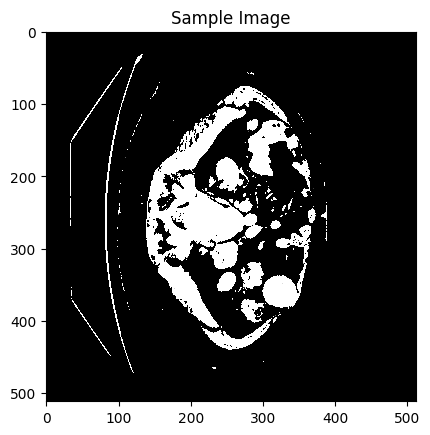

In [12]:
sample_image = train_images[2]
# Convert the PyTorch tensor to a NumPy array for visualization
sample_image_np = sample_image.squeeze(0).numpy()

# Display the image using matplotlib
plt.imshow(sample_image_np, cmap='gray', vmin = 0, vmax=1)  # Assuming the image is grayscale
plt.title('Sample Image')
plt.show()

In [13]:
# Convert data to PyTorch tensors
print(f'Train: {train_images.shape} || Mask: {mask_train.shape}')
train_dataset = TensorDataset(torch.Tensor(train_images), torch.Tensor(mask_train))

print(f'Val: {val_images.shape} || Mask: {mask_val.shape}')
val_dataset = TensorDataset(torch.Tensor(val_images), torch.Tensor(mask_val))

Train: torch.Size([894, 1, 512, 512]) || Mask: torch.Size([894, 512, 512])
Val: torch.Size([896, 1, 512, 512]) || Mask: torch.Size([896, 512, 512])


In [14]:
# DataLoader
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [15]:
# Create U-Net model using segmentation-models-pytorch
model = smp.Unet(
    "resnet34", in_channels=1, classes=3
)  # You can choose a different backbone
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model without validation data
train(model, criterion, optimizer, train_loader, val_loader, num_epochs=100)

Epoch 1/100, Loss: 0.09376975860712784
Validation Loss: 0.038928136454030336, Dice Coefficient: 0.0011130472412332892
Epoch 2/100, Loss: 0.011313686866612573
Validation Loss: 0.007646220522084539, Dice Coefficient: 0.04601003974676132
Epoch 3/100, Loss: 0.007268771312997809
Validation Loss: 0.007347177235975063, Dice Coefficient: 0.047464556992053986
Epoch 4/100, Loss: 0.005300345992769248
Validation Loss: 0.007088994990356566, Dice Coefficient: 0.007146117277443409
Epoch 5/100, Loss: 0.004710269263471544
Validation Loss: 0.006176440799858288, Dice Coefficient: 0.11808815598487854
Epoch 6/100, Loss: 0.003930773060086982
Validation Loss: 0.00530368478861679, Dice Coefficient: 0.1516495645046234
Epoch 7/100, Loss: 0.002900904633081934
Validation Loss: 0.004324122693755531, Dice Coefficient: 0.17301757633686066
Epoch 8/100, Loss: 0.003042404869120219
Validation Loss: 0.005793563809025467, Dice Coefficient: 0.08872221410274506
Epoch 9/100, Loss: 0.0024385979873581425
Validation Loss: 0.004